Lecture: AI I - Advanced 

Previous:
[**Chapter 4.1.2: Resnet**](../01_cv/02_resnet.ipynb)

---

# Chapter 4.2.1: Transformer with GPT2

- [Embedding](#embeddings-turning-words-into-numbers)
- [Tokenization](#tokenization-words-arent-the-unit)
- [Attention](#attention-how-the-model-reads)
- [Architectures](#three-transformer-architectures)
- [inference](#example-gpt-2-inference-with-temperature-top-k-and-top-p)

This excursion takes you inside the architecture that powers modern language models: the Transformer. You'll learn how raw text becomes numbers, how the model "reads" and understands relationships between words, and how different Transformer variants are designed for different tasks. We finish with a hands-on GPT-2 example that covers everything from embedding words to generating text with fine-grained control over the output.

## Embeddings: Turning Words Into Numbers

Neural networks work with numbers. They can't process the word "cat" directly—they need a numerical representation. But how do you turn language into math in a way that preserves meaning?

A naive approach would be one-hot encoding: assign each word in your vocabulary a unique index and represent it as a vector of zeros with a single 1 at that index. The word "cat" in a vocabulary of 50,000 words becomes a vector of 50,000 dimensions with exactly one non-zero entry. This works technically, but it's catastrophic for learning: the vector for "cat" and the vector for "dog" are equally far apart as "cat" and "spaceship." The encoding carries zero semantic information.

### What Embeddings Actually Do

An embedding maps each word to a dense, low-dimensional vector (typically 128–1024 dimensions) where geometric relationships reflect semantic relationships. Words that appear in similar contexts end up close together in this space. "Cat" and "dog" cluster near each other. "Paris" and "London" are neighbors. "King" and "Queen" are related by roughly the same vector offset as "Man" and "Woman."

These vectors are not hand-crafted—they are learned during training. The embedding layer is just a large lookup table of trainable parameters. When the model sees a word, it retrieves the corresponding vector. During backpropagation, the gradients update these vectors so that words used in similar ways drift closer together and words used differently drift apart.
Think of it as the model building its own internal dictionary—not one that defines words with other words, but one that captures the role each word plays across millions of sentences.

![Embedding Space](./data/01_gpt2/space.png)

## Tokenization: Words Aren't the Unit

Modern language models don't actually work at the word level. They use subword tokenization—splitting text into smaller, reusable chunks. The word "unhappiness" might become `["un", "happiness"]` or even `["un", "hap", "pi", "ness"]` depending on the tokenizer. This solves the problem of rare or unseen words: even a word the model has never seen before can be composed from familiar subword pieces.

GPT-2 uses Byte Pair Encoding (BPE), which starts by splitting text into individual characters, then iteratively merges the most frequently co-occurring pair into a new token. Over many iterations, this builds a vocabulary of common subword units that can represent any text efficiently.

In [81]:
from transformers import GPT2Tokenizer, GPT2Model

model = GPT2Model.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

word = "cat"
input_ids = tokenizer(word).input_ids
print(f"Token IDs for the word {word}:", input_ids)

print("Token Embeddings size:", model.wte.weight.shape)
print("Positional Embeddings size:", model.wpe.weight.shape)

token_embedding = model.wte.weight[input_ids[0]]
pos_embedding = model.wpe.weight[0]
embedding = token_embedding + pos_embedding

print(f"Token embedding for '{word}':", token_embedding.shape, token_embedding.detach().numpy()[:5])
print("Positional embedding for position 0:", pos_embedding.shape, pos_embedding.detach().numpy()[:5])
print("Embedding:", embedding.shape, embedding.detach().numpy()[:5])

Token IDs for the word cat: [9246]
Token Embeddings size: torch.Size([50257, 768])
Positional Embeddings size: torch.Size([1024, 768])
Token embedding for 'cat': torch.Size([768]) [-0.01636109 -0.09340496  0.24245903  0.13976254  0.03876501]
Positional embedding for position 0: torch.Size([768]) [-0.01882072 -0.1974186   0.00402672  0.01134686  0.06382412]
Embedding: torch.Size([768]) [-0.03518181 -0.29082358  0.24648575  0.1511094   0.10258913]


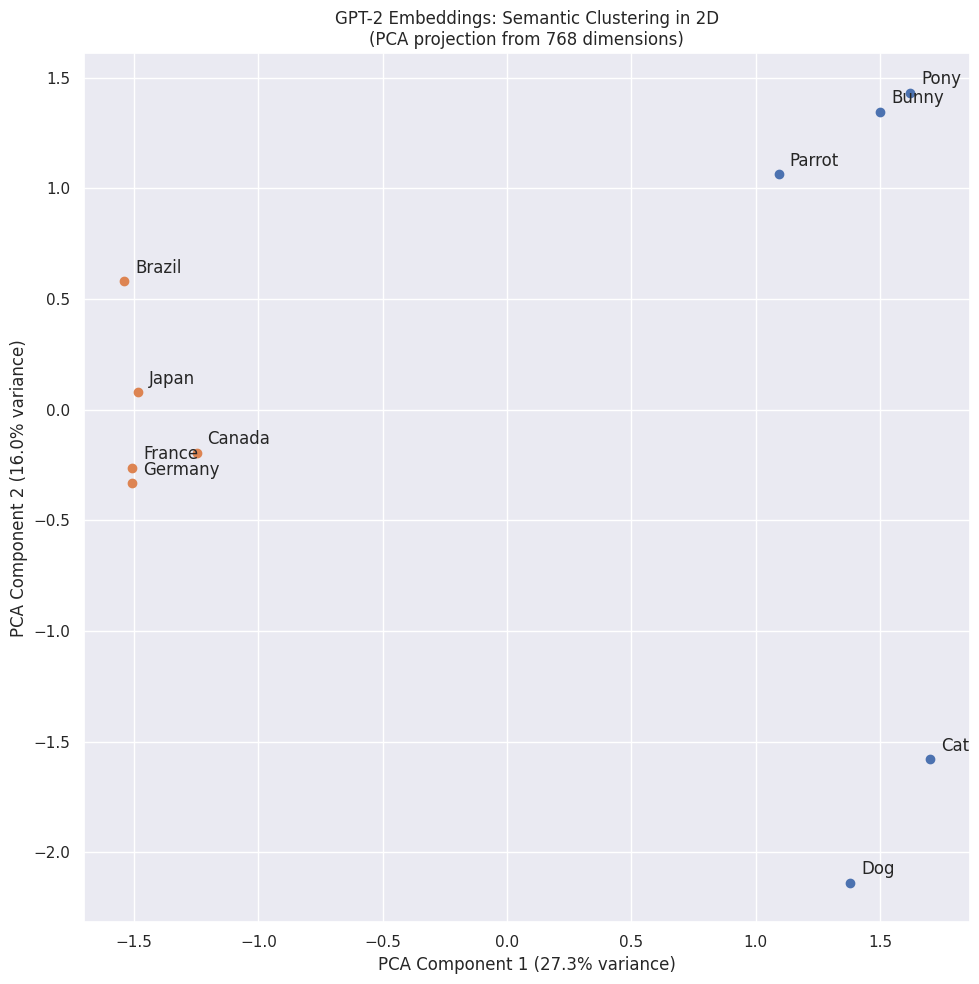

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

word_groups = {
    "animals": ["Cat", "Dog", "Parrot", "Pony", "Bunny"],
    "Countries": ["France", "Germany", "Japan", "Brazil", "Canada"],
}

embeddings = []
for word_list in word_groups.values():
    for word in word_list:
        input_ids = tokenizer(word).input_ids
        embedding = model.wte.weight[input_ids[0]]
        embeddings.append(embedding.detach().numpy())

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(embeddings_2d[:5, 0], embeddings_2d[:5, 1])
ax.scatter(embeddings_2d[5:, 0], embeddings_2d[5:, 1])

for i, word_list in enumerate(word_groups.values()):
    for j, word in enumerate(word_list):
        k = j + i * 5
        ax.annotate(word, (embeddings_2d[k, 0], embeddings_2d[k, 1]),
                textcoords="offset points", xytext=(8, 6))
        
ax.set_xlabel(f"PCA Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
ax.set_ylabel(f"PCA Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
ax.set_title("GPT-2 Embeddings: Semantic Clustering in 2D\n(PCA projection from 768 dimensions)")
fig.tight_layout()

**What to look for**: Words from the same semantic group cluster together—even though the model was never explicitly told "these words are related." This structure emerges purely from training on text.

## Attention: How the Model Reads

### The Problem Attention Solves

Imagine translating the sentence: "The cat sat on the mat because it was tired." What does "it" refer to? To understand this, you need to connect "it" back to "cat"—a relationship that spans several words. Earlier sequence models (like RNNs) processed text one word at a time, left to right, and had to compress the entire meaning of a sentence into a single fixed-size vector before making predictions. For long sentences, they forgot details at the beginning by the time they reached the end.

Attention solves this by allowing every word to directly "look at" every other word in the sentence and decide which ones are most relevant to understanding the current context. It's not sequential—it's a web of connections computed all at once.

### How Attention Works: The Intuition

Think of attention as a spotlight. For each word in the sentence, the model asks: "Which other words should I pay attention to right now?" The answer is a set of attention weights—numbers between 0 and 1 that sum to 1—distributed across all words. A high weight means "this word is very relevant"; a low weight means "I can mostly ignore this word."

The process works in three steps for each word:
1. **Ask a Question**: The current word is transformed into a Query—essentially asking "What am I looking for?"
2. **Offer Answers**: Every other word is transformed into a Key—essentially advertising "Here's what I can provide."
3. **Retrieve Information**: The Query is compared against all Keys to produce attention weights. Words whose Keys match the Query well get high weights. The final output is a weighted combination of all words' Values (a third transformation), blended according to these attention weights.

The result: each word's representation is enriched with context from the words that matter most to it.

### Multi-Head Attention

A single attention mechanism captures one type of relationship at a time. Multi-head attention runs multiple attention mechanisms in parallel—each "head" can focus on a different kind of relationship. One head might track grammatical subject-verb agreement, another might follow coreference ("it" → "cat"), another might capture proximity. The outputs of all heads are combined to produce a rich, multi-faceted representation.

GPT-2 small has 12 attention heads per layer and 12 layers—that's 144 individual attention patterns shaping how the model understands text.

In [85]:
from bertviz import head_view, model_view
from transformers import AutoModel

sentence = "The cat sat on the mat because it was tired."
model = AutoModel.from_pretrained("gpt2", output_attentions=True)

inputs = tokenizer.encode(sentence, return_tensors="pt")
outputs = model(inputs)
attention = outputs[-1]
tokens = tokenizer.convert_ids_to_tokens(inputs[0])

model_view(attention, tokens)  

<IPython.core.display.Javascript object>

In [88]:
# Layer 4, Head 3
head_view(attention, tokens, layer=4, heads=[3])

<IPython.core.display.Javascript object>

**What to explore in the visualization:**

- Find the token it and see which heads create a strong connection back to cat—this is coreference resolution in action.
- Look at punctuation tokens (like the period). Many heads learn to "park" attention on punctuation when a token has no strongly relevant neighbor—a common pattern called attention sinks.
- Compare early layers (which tend to capture local, syntactic patterns) with later layers (which capture more abstract, semantic relationships).

## Three Transformer Architectures

The original Transformer (Vaswani et al., 2017) combined two components: an Encoder that reads and understands the input, and a Decoder that generates the output. Since then, researchers discovered that for many tasks you don't need both. This led to three distinct architectural families, each optimized for a different type of task.

### Encoder-Only: Understanding Text

The encoder processes the entire input at once. Every token can attend to every other token—both forward and backward. This makes it ideal for tasks where you need to understand a piece of text rather than generate new text.

**What it's good at**: Sentence classification (is this review positive or negative?), named entity recognition (which words are names of people or places?), question answering (find the answer span within a passage), and semantic similarity.

**Key example**: BERT (Bidirectional Encoder Representations from Transformers). BERT reads text in both directions simultaneously, building a deep understanding of context. When you search for something on Google, BERT-like models help determine what your query actually means.

### Decoder-Only: Generating Text

The decoder processes tokens one at a time, left to right. Crucially, each token can only attend to previous tokens—not future ones. This is called causal masking or autoregressive processing. The model predicts the next token based solely on what came before.

**What it's good at**: Text generation, dialogue, code generation, and anything where the output is produced sequentially.

**Key example**: GPT-2 (and its successors GPT-3, GPT-4). These models are trained on a simple objective: given the words so far, predict the next word. Repeat this millions of times and the model learns an astonishing amount about language, reasoning, and even factual knowledge.

### Encoder-Decoder: Translating Between Sequences

This architecture combines both components. The encoder reads and fully understands the input. The decoder then generates the output, using attention to "look back" at the encoder's understanding at every step. This is perfect for tasks where the input and output are different sequences.

**What it's good at**: Machine translation (English → French), summarization (long article → short summary), and any sequence-to-sequence transformation.

**Key example**: T5 (Text-to-Text Transfer Transformer). T5 frames almost every NLP task as a text-to-text problem: the input is a text prompt (e.g., "translate English to French: Hello") and the output is the generated text (e.g., "Bonjour").

### Architecture Comparison at a Glance

| Architecture | Attention Direction | Primary Task | Example Model |
|--------------|---------------------|--------------|---------------|
| Encoder-Only | Bidirectional (full) | Understanding | BERT, DeBERTa |
| Decoder-Only | Unidirectional (causal) | Generation | GPT-4, Llama |
| Encoder-Decoder | Encoder: Bidirectional; Decoder: Unidirectional | Sequence-to-Sequence | T5, BART |

## Example: GPT-2 Inference with Temperature, Top-K, and Top-P

Now let's see exactly how GPT-2 generates text—and how we can control its behavior through decoding parameters.

### How Text Generation Actually Works

GPT-2 is a decoder-only model. Given an input sequence of tokens, it produces a probability distribution over its entire vocabulary for the next token. At each step, one token is sampled from this distribution, appended to the sequence, and then the model runs again to predict the next one. This repeats until a stopping condition is met.

The key insight: the raw output of the model is not a probability—it's a logit (an unnormalized score for each token in the vocabulary). Converting logits to probabilities requires the softmax function. And this is exactly where decoding parameters intervene.

In [134]:
import torch 

from torch.nn import functional as F
from transformers import AutoModelForCausalLM

sentence = "Berlin is the capital city of"
model = AutoModelForCausalLM.from_pretrained("gpt2")

inputs = tokenizer(sentence, return_tensors='pt')
with torch.no_grad():
    logits = model(**inputs).logits

print("Logits shape:", logits.shape)
print("Raw logits for next token prediction:", logits[0, -1, :5].numpy())

logits_norm = F.softmax(logits[0, -1, :], dim=-1)
print("Normalized probabilities for next token prediction:", logits_norm[:5].numpy())

Logits shape: torch.Size([1, 7, 50257])
Raw logits for next token prediction: [-84.52524  -81.976494 -84.491005 -89.79436  -86.00195 ]
Normalized probabilities for next token prediction: [9.1711975e-08 1.1730906e-06 9.4905914e-08 4.7214632e-10 2.0945794e-08]


In [135]:
results = torch.argsort(logits_norm, descending=True)

for r in results[:10]:
    print(f"{logits_norm[r] * 100:>6.3f}", "%", tokenizer.decode(r))

59.041 %  Germany
12.443 %  the
 6.865 %  Berlin
 2.055 %  Switzerland
 2.024 %  German
 1.180 %  Europe
 0.824 %  Bav
 0.662 %  Hamburg
 0.630 %  Austria
 0.542 %  a


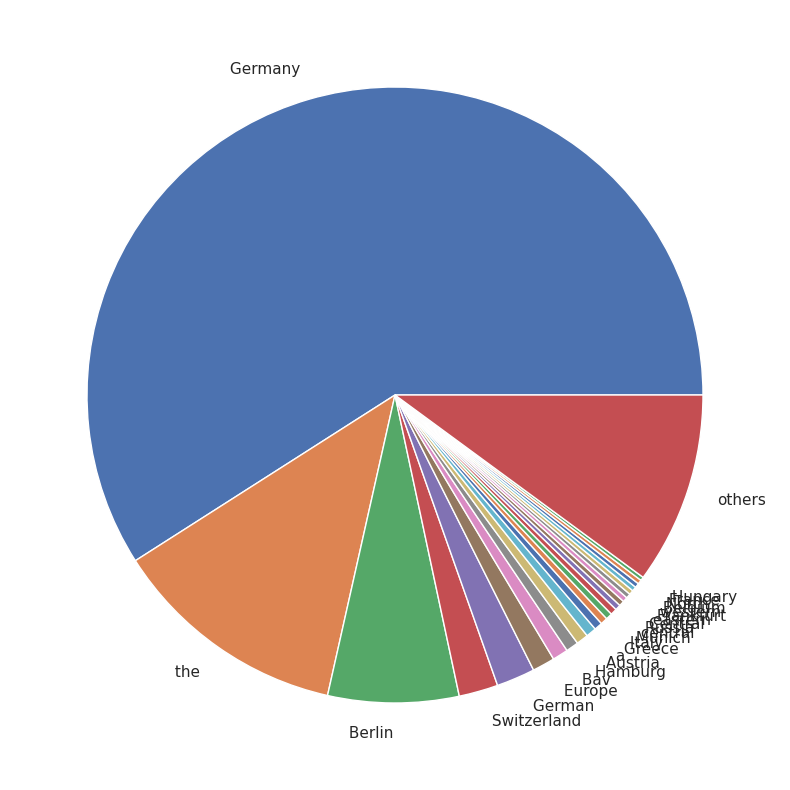

In [136]:
import numpy as np

threshold = 0.9

cumsum = np.cumsum(logits_norm[results])
l = len(cumsum[cumsum <= threshold])

x = np.append(logits_norm[results][:l], (1 - cumsum[l - 1]))
labels = [tokenizer.decode(r) for r in  results[:l]] + ["others"]

fig, ax = plt.subplots(figsize=(10, 10))
_ = ax.pie(x, labels=labels)

### The Three Decoding Parameters

**Temperature** controls how "creative" vs. "focused" the model is. It scales the logits before softmax is applied. A low temperature (e.g., 0.2) sharpens the distribution—making the most likely token almost certain. A high temperature (e.g., 1.5) flattens the distribution—making unlikely tokens much more probable. Temperature = 1.0 is the model's default behavior.

**Top-K** restricts sampling to only the K most probable tokens. Before drawing a sample, all tokens outside the top K are zeroed out. This prevents the model from ever picking a very unlikely "weird" token, no matter how creative the temperature setting is.

**Top-P** (Nucleus Sampling) is a more adaptive version of Top-K. Instead of a fixed number of candidates, it selects the smallest set of tokens whose cumulative probability exceeds a threshold P. If one token already has 95% probability, Top-P with P=0.9 might only consider that single token. If probability is spread out, it considers more candidates. This adapts dynamically to the model's confidence.

In [139]:
from transformers import pipeline

generator = pipeline('text-generation', model='gpt2')
output = generator(sentence, max_new_tokens=25)
output[0]["generated_text"]

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Berlin is the capital city of Germany, but it's also the capital of the world.\n\nThe most famous place to visit is Berlin, but it"

#### Temperature

In [141]:
output = generator(sentence, max_new_tokens=25, temperature=0.0001)
output[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Berlin is the capital city of Germany, and is home to the largest number of German-speaking refugees in Europe.\n\nThe city is home to the'

In [143]:
output = generator(sentence, max_new_tokens=25, temperature=2.0)
output[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Berlin is the capital city of European Central Asian giant Samsung\'s smartphone and social media services in Beijing — or an "innovation capital." However—though Berlin'

#### Top-K & Top-P

In [144]:
output = generator(sentence, max_new_tokens=25, top_p=0.5)
output[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


"Berlin is the capital city of Germany. It is also home to the largest number of German tourists.\n\nIn the early 1990s, the city's"

In [146]:
output = generator(sentence, max_new_tokens=25, top_k=10)
output[0]["generated_text"]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'Berlin is the capital city of Germany, where its population is roughly equal to that of the United States.\n\nThe new government of Chancellor Angela Merkel,'

---

Lecture: AI I - Advanced 

Next: [**Chapter 4.2.2: Data Structures**](../02_python/02_data_structures.ipynb)